In [154]:
from __future__ import division

import os
import multiprocessing as mp
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from keras.preprocessing import image
from scipy.spatial.distance import cosine

from learning2learn.images import generate_random_shape

In [150]:
def adjust_contrast(img, factor):
    assert factor >= 1.
    img_p = 1. - img
    img_p /= factor
    img_p = 1. - img_p
    
    return img_p

def generate_image(shape, color, texture, target_size=(200, 200), adapt_contrast=False):
    # Generate the base color
    img_color = np.ones(shape=target_size+(3,), dtype=np.float32)*color
    # Generate the base texture
    img_texture = image.load_img(
        '../data/textures/%s' % texture, 
        target_size=target_size, 
        interpolation='bicubic'
    )
    img_texture = image.img_to_array(img_texture) / 255.
    img_texture = img_texture[:,:,0]
    if adapt_contrast:
        mean = np.mean(img_texture)
        if mean < 0.5725:
            factor = np.power(0.5725/mean, 2)
            img_texture = adjust_contrast(img_texture, factor)
    # Put it all together
    img = np.zeros(shape=target_size+(4,), dtype=np.float32)
    img[:,:,:3] = img_color
    img[:,:,3] = img_texture
    # Cutout the shape
    p = mplpath.Path(shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if not p.contains_point((i, j)):
                img[j,i,:] = np.ones_like(img[j,i])
                
    return img

In [141]:
def generate_colors():
    nb_colors = 27
    nb_bins = 3
    vals = np.linspace(0, 0.95, nb_bins)
    colors = np.zeros(shape=(nb_colors,3))
    i = 0
    for r in vals:
        for g in vals:
            for b in vals:
                colors[i] = np.asarray([r, g, b])
                i += 1
    
    return colors

In [142]:
SHAPE_SET = [generate_random_shape(0, 200, 0, 200, 40) for _ in range(50)]
COLOR_SET = generate_colors()
TEXTURE_SET = sorted([file for file in os.listdir('../data/textures') if file.endswith('tiff')])

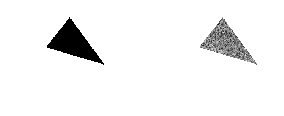

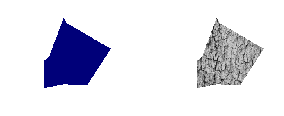

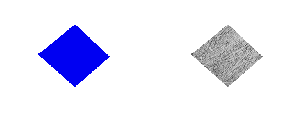

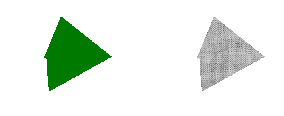

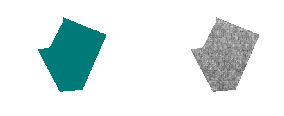

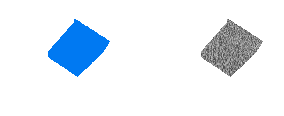

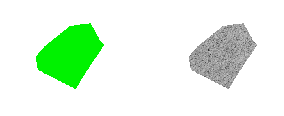

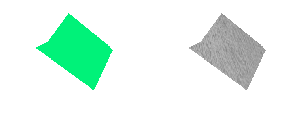

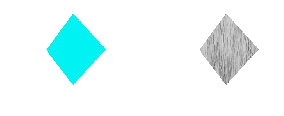

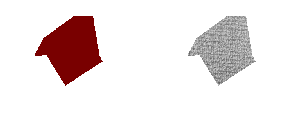

In [143]:
for i in range(10):
    img = generate_image(SHAPE_SET[i], COLOR_SET[i], TEXTURE_SET[i])
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 1.5))
    axes[0].imshow(img[:,:,:3], vmin=0., vmax=1.)
    axes[0].axis('off')
    axes[1].imshow(img[:,:,3], cmap='gray', vmin=0., vmax=1.)
    axes[1].axis('off')
    plt.show()
    print('\n')

In [144]:
ix = [5,7,9,11,13,15,17,19,21,23]
color_set = COLOR_SET[ix]
texture_set = TEXTURE_SET
shape_set = SHAPE_SET

In [167]:
def make_trial(shape_set, color_set, texture_set, target_size=(200, 200), adapt_contrast=False):
    # randomly select 3 of each feature
    s1, s2, s3 = np.random.choice(range(len(shape_set)), 3, replace=False)
    c1, c2, c3 = np.random.choice(range(len(color_set)), 3, replace=False)
    shape1, shape2, shape3 = shape_set[s1], shape_set[s2], shape_set[s3]
    color1, color2, color3 = color_set[c1], color_set[c2], color_set[c3]
    texture1, texture2, texture3 = np.random.choice(texture_set, 3, replace=False)
    # generate the trial images
    baseline = generate_image(shape1, color1, texture1, target_size, adapt_contrast)
    shape_match = generate_image(shape1, color2, texture2, target_size, adapt_contrast)
    color_match = generate_image(shape2, color1, texture3, target_size, adapt_contrast)
    texture_match = generate_image(shape3, color3, texture1, target_size, adapt_contrast)
    #print(texture1, texture2, texture3, texture1)
    
    return np.asarray([baseline, shape_match, color_match, texture_match])

def make_trial_wrapper(tup):
    return make_trial(tup[0], tup[1], tup[2], tup[3], tup[4])

def build_test_trials(shape_set, color_set, texture_set, nb_trials, 
                      target_size=(200, 200), adapt_contrast=False):
    tups = [(shape_set, color_set, texture_set, target_size, adapt_contrast)
            for _ in range(nb_trials)]
    p = mp.Pool()
    trials = p.map(make_trial_wrapper, tups)
    
    return np.concatenate(trials)
#     imgs = np.zeros(shape=(4*nb_trials,)+target_size+(4,))
#     for i in range(nb_trials):
#         imgs[4*i:4*(i+1)] = make_trial(shape_set, color_set, texture_set, target_size, adapt_contrast)
    
#     return imgs

In [173]:
nb_trials = 100
imgs = build_test_trials(shape_set, color_set, texture_set, nb_trials, adapt_contrast=True)

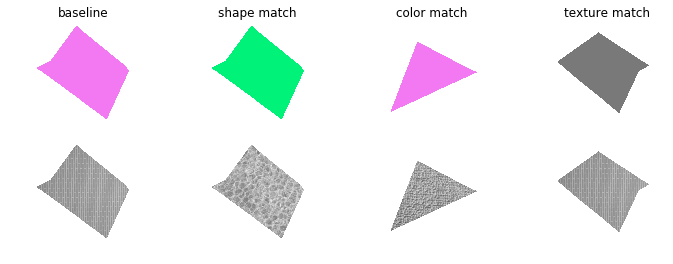

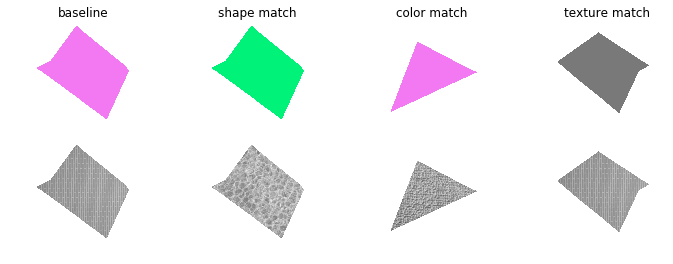

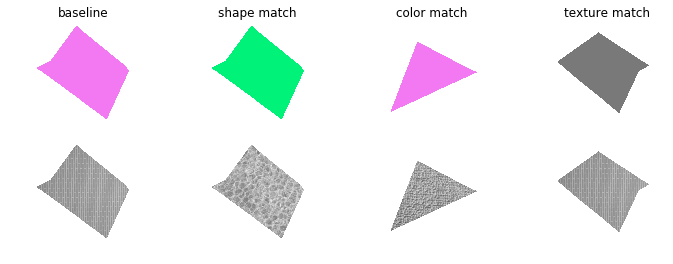

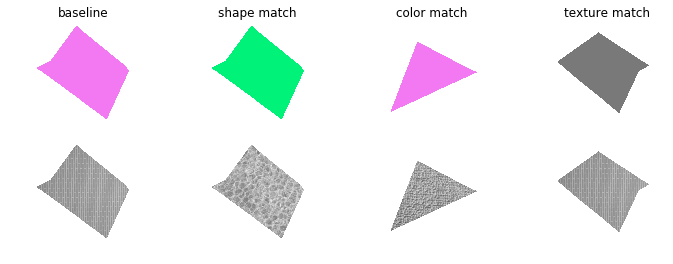

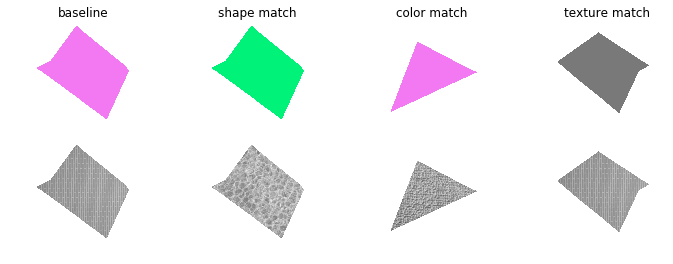

In [172]:
for i in range(5):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,4))
    # plot colors
    axes[0,0].imshow(imgs[4*i,:,:,:3], vmin=0., vmax=1.)
    axes[0,0].axis('off')
    axes[0,0].set_title('baseline')
    axes[0,1].imshow(imgs[4*i+1,:,:,:3], vmin=0., vmax=1.)
    axes[0,1].axis('off')
    axes[0,1].set_title('shape match')
    axes[0,2].imshow(imgs[4*i+2,:,:,:3], vmin=0., vmax=1.)
    axes[0,2].axis('off')
    axes[0,2].set_title('color match')
    axes[0,3].imshow(imgs[4*i+3,:,:,:3], vmin=0., vmax=1.)
    axes[0,3].axis('off')
    axes[0,3].set_title('texture match')
    # plot textures
    axes[1,0].imshow(imgs[4*i,:,:,3], cmap='gray', vmin=0., vmax=1.)
    axes[1,0].axis('off')
    #axes[1,0].set_title('baseline')
    axes[1,1].imshow(imgs[4*i+1,:,:,3], cmap='gray', vmin=0., vmax=1.)
    axes[1,1].axis('off')
    #axes[1,1].set_title('shape match')
    axes[1,2].imshow(imgs[4*i+2,:,:,3], cmap='gray', vmin=0., vmax=1.)
    axes[1,2].axis('off')
    #axes[1,2].set_title('color match')
    axes[1,3].imshow(imgs[4*i+3,:,:,3], cmap='gray', vmin=0., vmax=1.)
    axes[1,3].axis('off')
    #axes[1,3].set_title('texture match')
    plt.show()
    print('\n\n')

In [ ]:
# Maybe we should adjust the contrast of the textures so that they're all about equal... let's try

In [136]:
def adjust_contrast(img, factor):
    assert factor >= 1.
    img_p = 1. - img
    img_p /= factor
    img_p = 1. - img_p
    
    return img_p

In [83]:
def generate_texture_img(texture):
    img_texture = image.load_img('../data/textures/%s' % texture, target_size=(200, 200), interpolation='bicubic')
    img_texture = image.img_to_array(img_texture) / 255.

    return img_texture

In [58]:
imgs_texture = np.asarray(
    [generate_texture_img(t) for t in TEXTURE_SET]
)
imgs_texture = imgs_texture[:,:,:,-1]

In [114]:
def show_distribution(img):
#     mean = np.mean(img)
#     std = np.std(img)
#     low = mean - 2*std
#     print('Low: %0.3f'% low)
    plt.figure(figsize=(5,3))
    plt.hist(img.flatten(), bins=50)
    plt.xlim(0.,1.)
    plt.show()

texture: 1.1.01.tiff


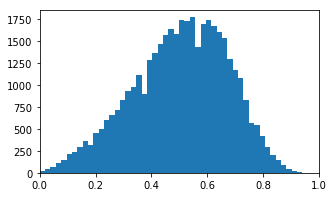



texture: 1.1.02.tiff


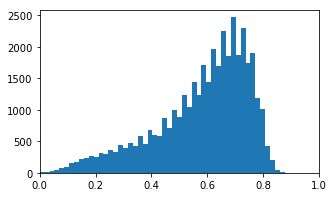



texture: 1.1.03.tiff


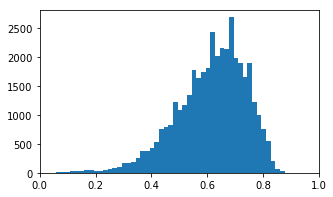



texture: 1.1.04.tiff


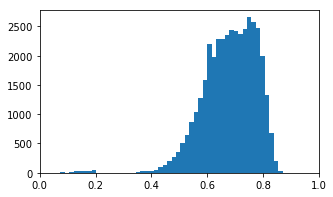



texture: 1.1.05.tiff


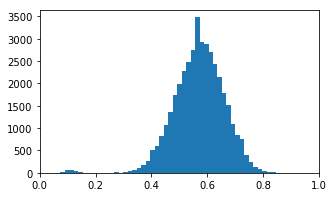



texture: 1.1.06.tiff


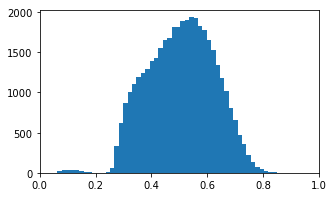



texture: 1.1.07.tiff


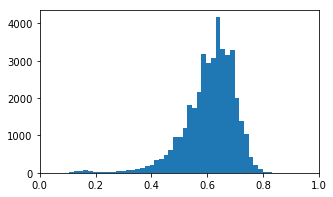



texture: 1.1.08.tiff


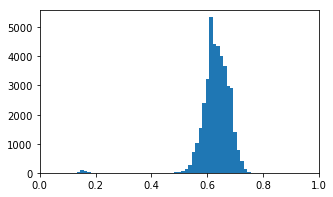



texture: 1.1.09.tiff


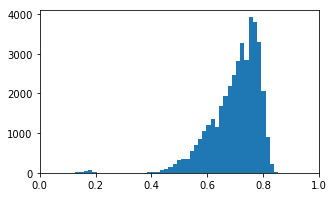



texture: 1.1.10.tiff


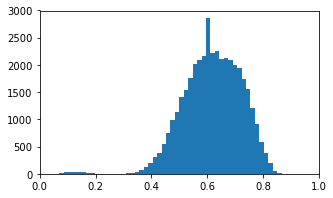



texture: 1.1.11.tiff


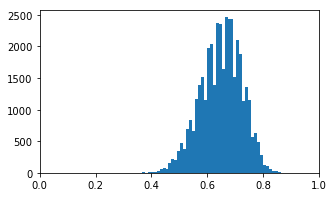



texture: 1.1.12.tiff


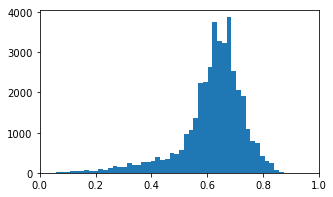



texture: 1.1.13.tiff


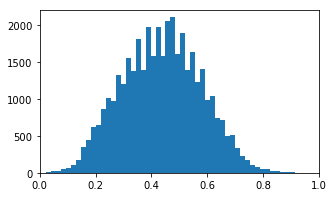



texture: 1.2.01.tiff


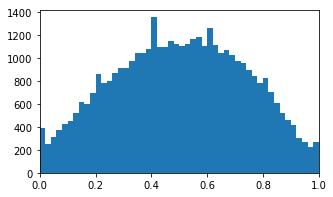



texture: 1.2.02.tiff


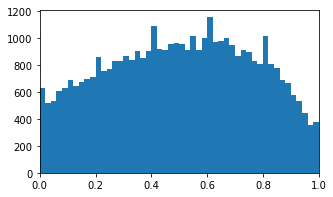



texture: 1.2.03.tiff


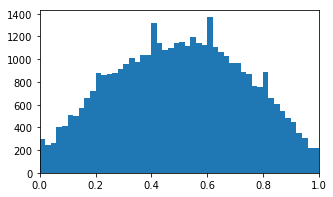



texture: 1.2.04.tiff


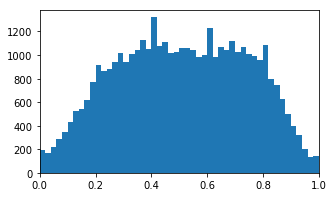



texture: 1.2.05.tiff


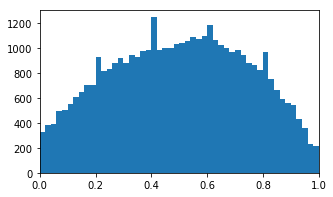



texture: 1.2.06.tiff


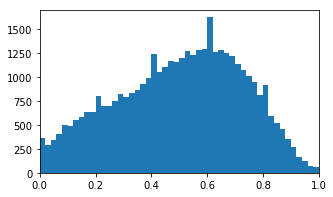



texture: 1.2.07.tiff


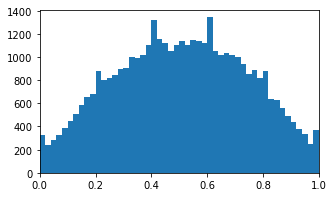



texture: 1.2.08.tiff


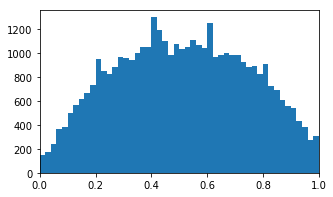



texture: 1.2.09.tiff


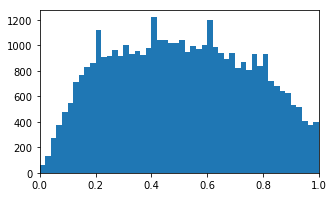



texture: 1.2.10.tiff


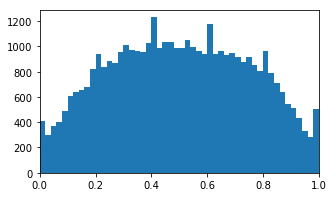



texture: 1.2.11.tiff


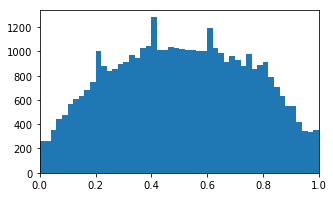



texture: 1.2.12.tiff


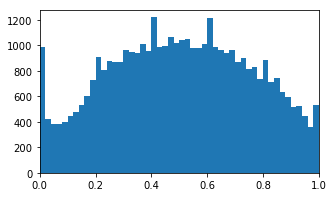



texture: 1.2.13.tiff


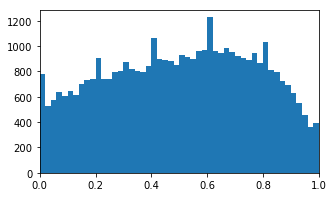



texture: 1.3.01.tiff


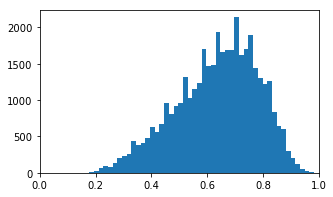



texture: 1.3.02.tiff


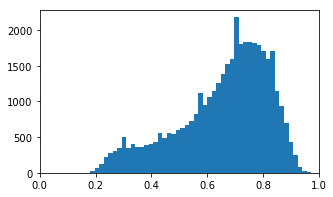



texture: 1.3.03.tiff


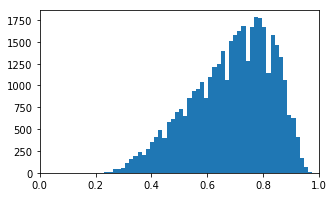



texture: 1.3.04.tiff


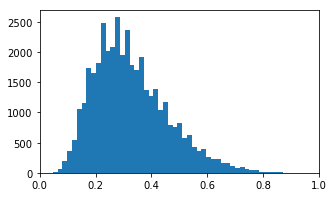

In [115]:
for i in range(30):
    print('texture: %s' % TEXTURE_SET[i])
    show_distribution(imgs_texture[i])
    print('\n')

In [139]:
mean_activation

0.5724898

In [110]:
mean_activation = np.mean(imgs_texture)

texture: 1.1.01.tiff
contrast factor: 1.287


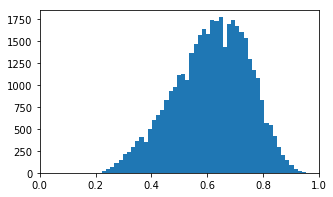



texture: 1.1.02.tiff
contrast factor: 0.966


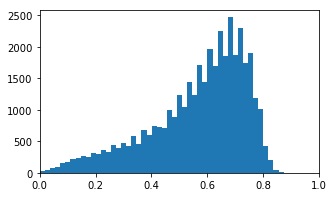



texture: 1.1.03.tiff
contrast factor: 0.867


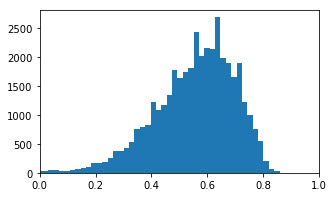



texture: 1.1.04.tiff
contrast factor: 0.707


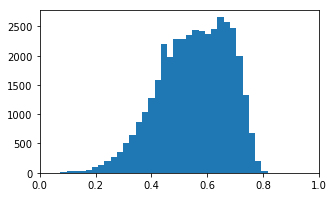



texture: 1.1.05.tiff
contrast factor: 1.004


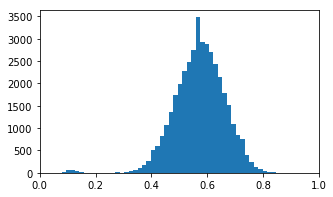



texture: 1.1.06.tiff
contrast factor: 1.283


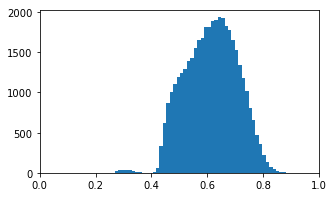



texture: 1.1.07.tiff
contrast factor: 0.879


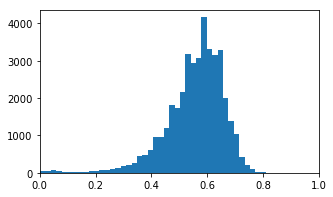



texture: 1.1.08.tiff
contrast factor: 0.818


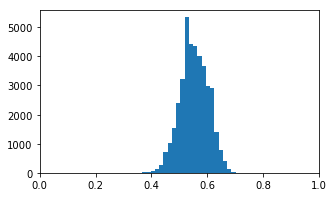



texture: 1.1.09.tiff
contrast factor: 0.668


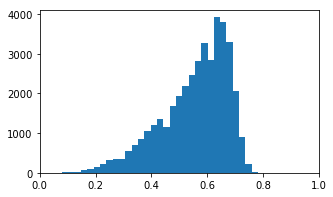



texture: 1.1.10.tiff
contrast factor: 0.853


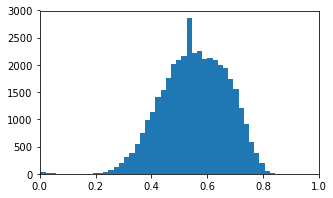



texture: 1.1.11.tiff
contrast factor: 0.774


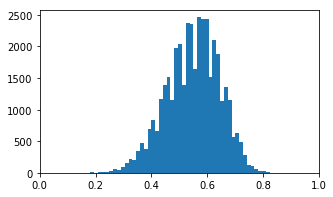



texture: 1.1.12.tiff
contrast factor: 0.851


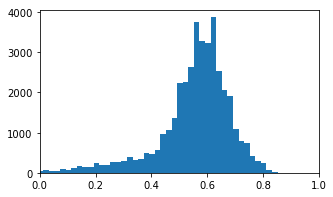



texture: 1.1.13.tiff
contrast factor: 1.718


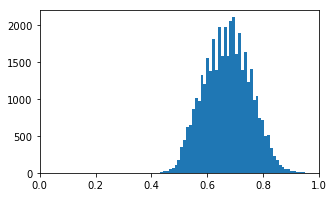



texture: 1.2.01.tiff
contrast factor: 1.304


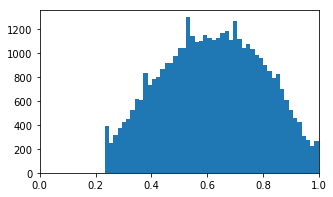



texture: 1.2.02.tiff
contrast factor: 1.308


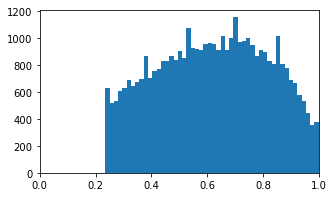



texture: 1.2.03.tiff
contrast factor: 1.308


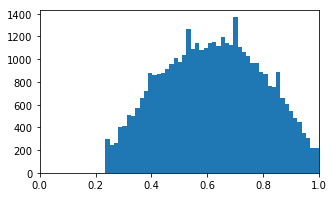



texture: 1.2.04.tiff
contrast factor: 1.261


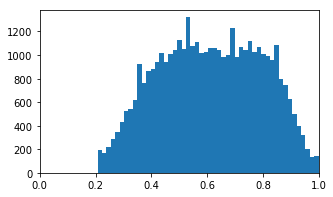



texture: 1.2.05.tiff
contrast factor: 1.305


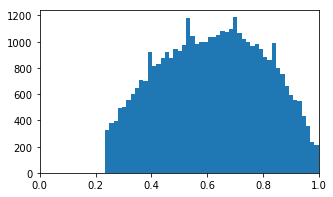



texture: 1.2.06.tiff
contrast factor: 1.303


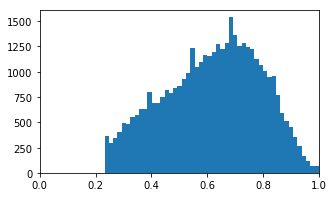



texture: 1.2.07.tiff
contrast factor: 1.273


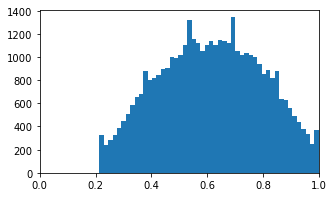



texture: 1.2.08.tiff
contrast factor: 1.259


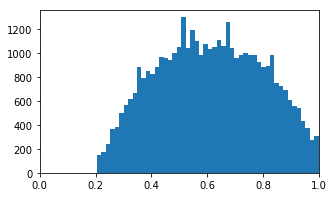



texture: 1.2.09.tiff
contrast factor: 1.283


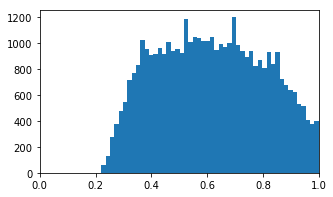



texture: 1.2.10.tiff
contrast factor: 1.305


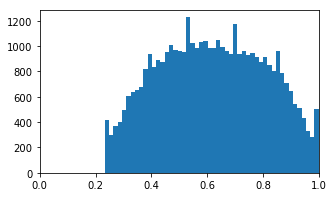



texture: 1.2.11.tiff
contrast factor: 1.284


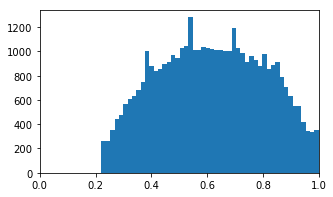



texture: 1.2.12.tiff
contrast factor: 1.298


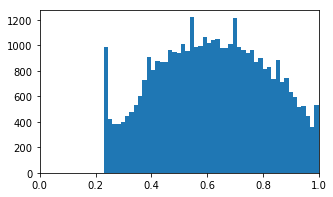



texture: 1.2.13.tiff
contrast factor: 1.297


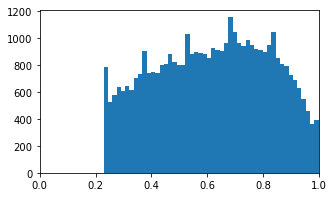



texture: 1.3.01.tiff
contrast factor: 0.811


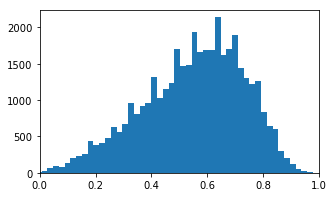



texture: 1.3.02.tiff
contrast factor: 0.758


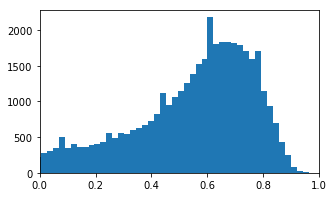



texture: 1.3.03.tiff
contrast factor: 0.694


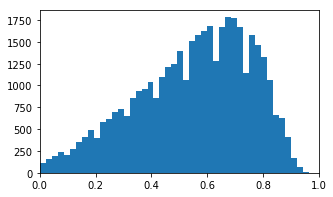



texture: 1.3.04.tiff
contrast factor: 3.069


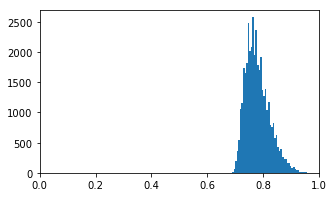

In [118]:
for i in range(30):
    print('texture: %s' % TEXTURE_SET[i])
    img = imgs_texture[i]
    mean = np.mean(img)
    factor=np.power(mean_activation/mean, 2)
    print('contrast factor: %0.3f' % factor)
    img = adjust_contrast(img, factor)
    show_distribution(img)
    print('\n')

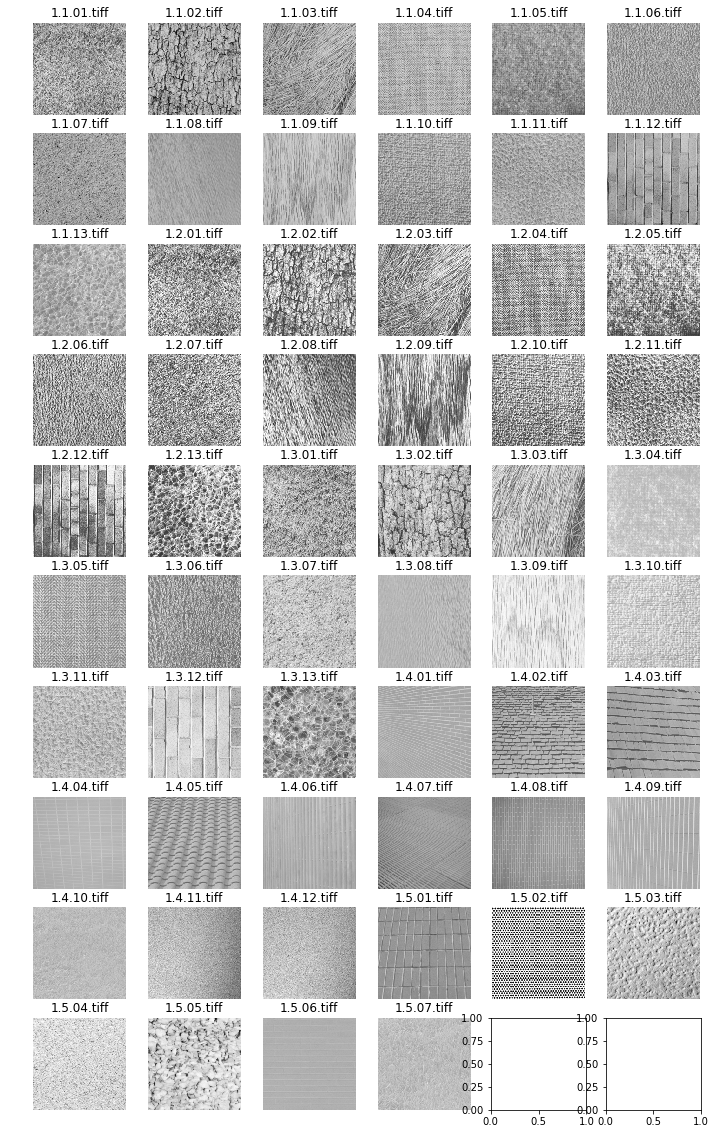

In [137]:
minouts = []
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(12, 20))
for i in range(10):
    for j in range(6):
        ix = i*6+j
        if ix < len(imgs_texture):
            img = imgs_texture[ix]
            mean = np.mean(img)
            if mean < mean_activation:
                contrast_factor = np.power(mean_activation/mean, 2)
                #contrast_factor = 2*(mean_activation/mean)
                img = adjust_contrast(img, contrast_factor)
            axes[i,j].imshow(img, cmap='gray', vmin=0., vmax=1.)
            axes[i,j].axis('off')
            axes[i,j].set_title(TEXTURE_SET[ix])
            if np.min(img) < 0:
                minouts.append((TEXTURE_SET[ix], np.min(img)))
plt.show()

In [138]:
minouts

[]

In [102]:
imgs_texture = np.asarray(
    [generate_texture_img(t) for t in TEXTURE_SET]
)
imgs_texture = imgs_texture[:,:,:,-1]

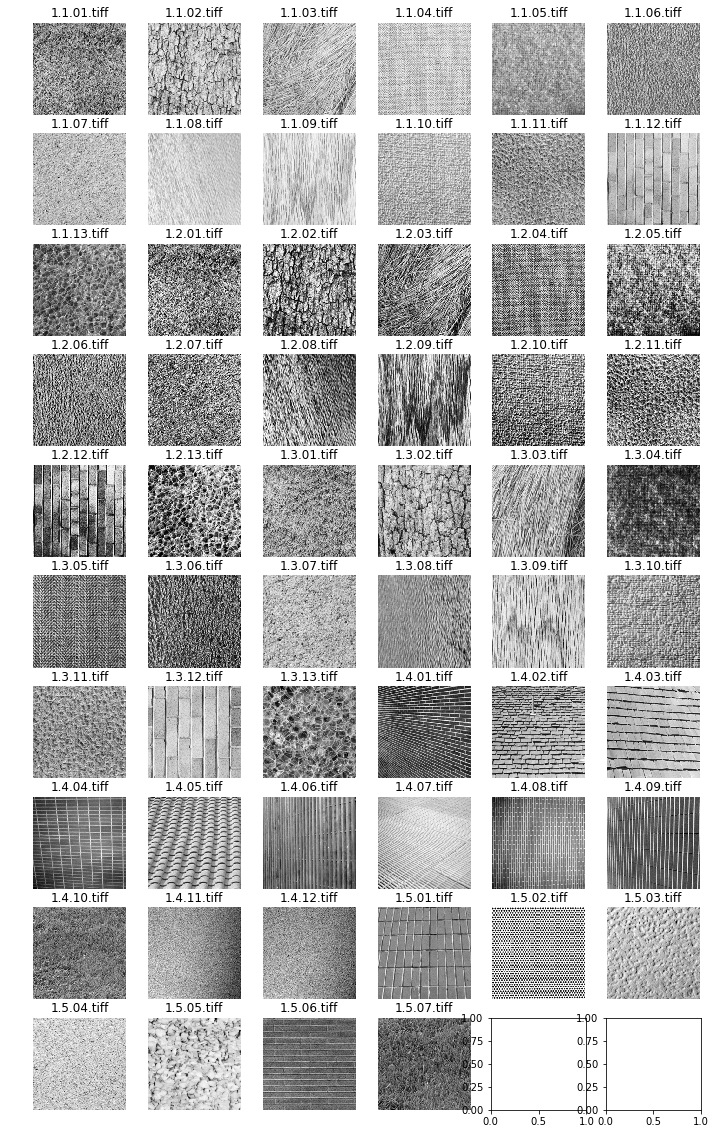

In [103]:
fig, axes = plt.subplots(nrows=10, ncols=6, figsize=(12, 20))
for i in range(10):
    for j in range(6):
        ix = i*6+j
        if ix < len(imgs_texture):
            axes[i,j].imshow(imgs_texture[ix], cmap='gray')
            axes[i,j].axis('off')
            axes[i,j].set_title(TEXTURE_SET[ix])
plt.show()